In [ ]:
! pip install git+https://github.com/TutteInstitute/datamapplot.git

In [1]:
import io
from pathlib import Path
import zipfile

import datamapplot
import numpy as np
import pandas as pd
import requests
import scipy
import seaborn as sns
import umap
import vectorizers
import vectorizers.transformers

## Load Data

In [2]:
# Data URL from https://www.cs.cornell.edu/~arb/data/cat-edge-Cooking/
url = "https://drive.google.com/uc?export=download&id=16BTDEv3AC9l81FeU2US5nG30_CGsRTqk"
response = requests.get(url)
zip_file = io.BytesIO(response.content)
with zipfile.ZipFile(zip_file) as zf:
    print(zf.namelist())
    files = {name: zf.read(name) for name in zf.namelist()}

['cat-edge-Cooking/', 'cat-edge-Cooking/hyperedges.txt', 'cat-edge-Cooking/hyperedge-labels.txt', 'cat-edge-Cooking/hyperedge-label-identities.txt', 'cat-edge-Cooking/node-labels.txt', 'cat-edge-Cooking/README.txt']


Following https://github.com/vpoulin/Hypergraph-Vectorization-recipes/blob/master/notebooks/recipes-00-data-setup.ipynb .

In [3]:
ingredients_id = pd.read_csv(io.BytesIO(files["cat-edge-Cooking/node-labels.txt"]), sep='\t', header=None)
ingredients_id.index = [x+1 for x in ingredients_id.index]
ingredients_id.columns = ['Ingredient']

In [4]:
recipes_with_id = [[int(ingredient) for ingredient in recipe.split("\t")] for recipe in
 files["cat-edge-Cooking/hyperedges.txt"].decode("utf8").strip().split("\n")]

In [5]:
recipes_all = [[ingredients_id.loc[int(i)]['Ingredient'] for i in x] for x in recipes_with_id]

In [6]:
recipe_min_size = 3
recipes = [recipe for recipe in recipes_all if len(recipe) > recipe_min_size]

In [7]:
keep_recipes = np.array([len(recipe) > recipe_min_size for recipe in recipes_all])

In [8]:
recipes_label_id_all = pd.read_csv(io.BytesIO(files["cat-edge-Cooking/hyperedge-labels.txt"]), sep='\t', header=None)
recipes_label_id_all.columns = ['label']
recipes_label_id = recipes_label_id_all.iloc[keep_recipes].reset_index()

In [9]:
label_name = pd.read_csv(io.BytesIO(files["cat-edge-Cooking/hyperedge-label-identities.txt"]), sep='\t', header=None)
label_name.columns = ['country']
label_name.index = [x+1 for x in label_name.index]

In [10]:
recipes_country = [label_name.loc[i]['country'] for i in recipes_label_id.label] 

In [11]:
recipe_metadata = pd.DataFrame()
recipe_metadata['Country'] = recipes_country
recipe_metadata['Ingredients'] = recipes
recipe_metadata['Recipe_size'] = [len(x) for x in recipes]

In [12]:
region_to_countries_map = {
    'asian' : ('chinese', 'filipino', 'japanese','korean', 'thai', 'vietnamese'),
    'american' : ('brazilian', 'mexican', 'southern_us'),
    'english' : ('british', 'irish'),
    'islands' : ('cajun_creole', 'jamaican'),
    'europe' : ('french', 'italian', 'spanish'),
    'others' : ('greek', 'indian', 'moroccan', 'russian')
}

In [13]:
country_to_region_map = {country: region for region, countries in region_to_countries_map.items() for country in countries}

In [14]:
recipe_metadata["Region"] = recipe_metadata["Country"].map(country_to_region_map)

## Embed

Following https://github.com/vpoulin/Hypergraph-Vectorization-recipes/blob/master/notebooks/recipes-03-joint-annotated.ipynb .

In [15]:
def vertexCooccurrenceVectorizer(hyperedges):
    vertexCooccurrence_vectorizer = vectorizers.TokenCooccurrenceVectorizer().fit(hyperedges)
    
    incidence_vectorizer = vectorizers.NgramVectorizer(
        token_dictionary=vertexCooccurrence_vectorizer.token_label_dictionary_
    ).fit(hyperedges)

    H = incidence_vectorizer.transform(hyperedges)
    
    M_cooccurrence = (H.T@H)
    M_cooccurrence.setdiag(0)
    M_cooccurrence.eliminate_zeros()
    
    vertexCooccurrence_vectorizer.cooccurrences_ = M_cooccurrence
    
    return(vertexCooccurrence_vectorizer)

In [16]:
ingredient_vectorizer = vertexCooccurrenceVectorizer(recipes)
ingredient_vectors = ingredient_vectorizer.reduce_dimension(dimension=60, algorithm="randomized")
n_ingredients = len(ingredient_vectorizer.token_index_dictionary_)
ingredients = [ingredient_vectorizer.token_index_dictionary_[i] for i in range(n_ingredients)]

/work/home/rtmills/.local/lib/python3.11/site-packages/numba/core/utils.py:643: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  warnings.warn("First-class function type feature is experimental",


In [17]:
ingredient_metadata = pd.DataFrame({"Ingredients": [[x] for x in ingredients], "Country": "Unlabelled", "Region": "Unlabelled", "Recipe_size": 1})

df = pd.concat([recipe_metadata, ingredient_metadata], axis=0)

n_recipes = len(recipes)

is_ingredient = np.hstack([np.zeros(n_recipes),
                           np.ones(n_ingredients)]).astype(bool)

df["Is_ingredient"] = is_ingredient

In [18]:
incidence_vectorizer = vectorizers.NgramVectorizer(
    token_dictionary=ingredient_vectorizer.token_label_dictionary_
).fit(recipes)

incidence_matrix = incidence_vectorizer.transform(recipes)

In [19]:
info_weighted_incidence = vectorizers.transformers.InformationWeightTransformer(
    prior_strength=1e-1,
    approx_prior=False,
).fit_transform(incidence_matrix)

In [20]:
info_doc_with_identity = scipy.sparse.vstack([info_weighted_incidence, scipy.sparse.identity(n_ingredients)])

In [21]:
joint_vectors_unsupervised = vectorizers.ApproximateWassersteinVectorizer(
    normalization_power=0.25,
    random_state=42,
).fit_transform(info_doc_with_identity, vectors=ingredient_vectors)

In [22]:
joint_vectors_mapper = umap.UMAP(metric="cosine", random_state=42).fit(joint_vectors_unsupervised)

/home/jupyterhub/.conda/envs/jupyterhub/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [23]:
df["x"] = joint_vectors_mapper.embedding_[:, 0]
df["y"] = joint_vectors_mapper.embedding_[:, 1]

In [24]:
df.to_parquet(Path("../data/recipes.parquet"))

## Data Map

In [2]:
df = pd.read_parquet(Path("../data/recipes.parquet"))

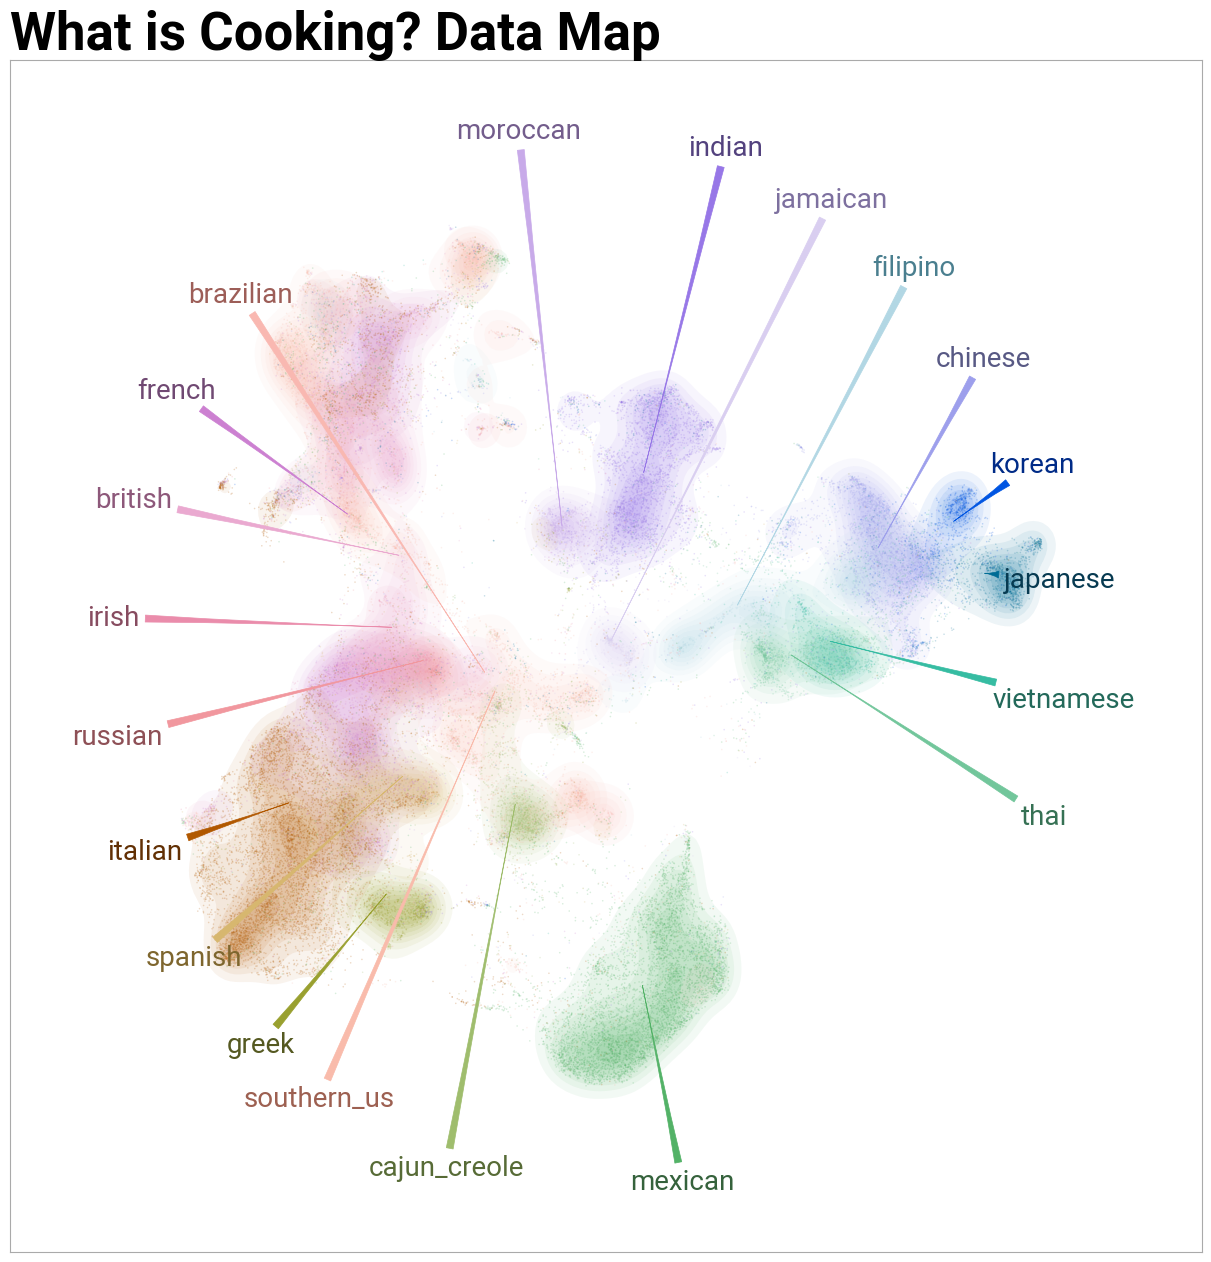

In [26]:
fig, ax = datamapplot.create_plot(
    df.loc[~df["Is_ingredient"], ["x", "y"]].to_numpy(),
    df.loc[~df["Is_ingredient"], "Country"],
    title="What is Cooking? Data Map",
    label_font_size=20,
    use_medoids=True,
    color_label_arrows=True, 
    arrowprops={"arrowstyle": "wedge, tail_width=0.25, shrink_factor=0.25"},
)

In [7]:
plot = datamapplot.create_interactive_plot(
    df.loc[~df["Is_ingredient"], ["x", "y"]].to_numpy(),
    df.loc[~df["Is_ingredient"], "Country"],
    df.loc[~df["Is_ingredient"], "Region"],
    title="What is Cooking? Data Map",
    enable_search=True,
    inline_data=True,
    hover_text=df.loc[~df["Is_ingredient"], "Ingredients"].map(", ".join),
)

In [8]:
plot

<InteractiveFigure width=100% height=800>

In [9]:
plot.save(Path("../recipes_datamapplot.html"))